# Quick demo of the package

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os 
os.chdir('..')
from fairness.metrics import *
from fairness.approximatemultiwasserstein import MultiWasserStein
from visualization.visualization import viz_fairness_distrib, waterfall_plot, arrow_plot, arrow_plot_permutations, permutations_cols, calculate_perm_wst


## Simulation of the dataset 

In [4]:
# 10 000 observations
# Y : Income
# MSA : Gender, Nb_child

size = 10000

age = np.random.randint(18, 66, size)

gender = np.random.choice(['m', 'w', 'nb'], size)

nb_child = np.random.choice([0,1,2], size)

# Generate incomes regarding gender with Gamma distributions
salaries = []
for g in gender:
    if g == 'm':
        salary = np.random.gamma(20, 0.5)
    elif g == 'w':
        salary = np.random.gamma(2, 2)
    else:
        salary = np.random.gamma(0.5, 6)
    salaries.append(salary)
   
for i, n in enumerate(nb_child):
    if n == 0:
        salaries[i] += np.random.binomial(6, 0.75)
    elif g == 1:
        salaries[i] += np.random.binomial(5, 0.66)
    else:
        salaries[i] += np.random.binomial(1, 0.2)
    

# Creation of the dataframe
df = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'Nb_child': nb_child,
    'Income': salaries
})

In [5]:
# Creation of the objects useful for the package
x_ssa = df[['Gender','Nb_child']].to_numpy()
y_ssa = df['Income'].to_numpy()
x_ssa_calib, x_ssa_test, y_calib, y_test = train_test_split(x_ssa,y_ssa, test_size=0.3)
y_true = y_test + np.random.uniform(-1,1,size=len(y_test))

## Test the Wasserstein class

### Exact fairness

In [6]:
# Instance of Wasserstein class
wst = MultiWasserStein()
wst.fit(y_calib, x_ssa_calib)
print("y_fair :", wst.transform(y_test, x_ssa_test)) # returns the y_fair

# To have all the steps of sequential fairness, you can return the dictionnary 
print("y_sequentially_fair :", wst.get_sequential_fairness())

y_fair : [4.77624099 4.72188883 8.41018138 ... 7.11507539 8.2267001  7.39959717]
y_sequentially_fair : {'Base model': array([12.0742855 ,  6.00628481, 11.47672398, ...,  2.23254531,
       15.39194921,  2.5259592 ]), 'sens_var_1': array([ 7.65606083,  7.57692964,  6.91049226, ...,  5.59095156,
       11.40338889,  5.8266432 ]), 'sens_var_2': array([4.77624099, 4.72188883, 8.41018138, ..., 7.11507539, 8.2267001 ,
       7.39959717])}


### Approximate fairness

In [7]:
# Instance of Wasserstein class with approximate fairness
approx_wst = MultiWasserStein()
approx_wst.fit(y_calib, x_ssa_calib)
y_fair = approx_wst.transform(y_test, x_ssa_test, epsilon = [0.1, 0.2])
print("y_fair :", y_fair) # returns the y_fair

# To have all the steps of sequential fairness, you can return the dictionnary 
y_fair_dict = approx_wst.get_sequential_fairness()
print("y_sequentially_fair :", y_fair_dict)

y_fair : [5.80086669 5.16698229 8.59261183 ... 6.45228626 9.24780479 6.70774233]
y_sequentially_fair : {'Base model': array([12.0742855 ,  6.00628481, 11.47672398, ...,  2.23254531,
       15.39194921,  2.5259592 ]), 'sens_var_1': array([ 8.0978095 ,  7.41979989,  7.36714494, ...,  5.25509429,
       11.80216877,  5.49657121]), 'sens_var_2': array([5.80086669, 5.16698229, 8.59261183, ..., 6.45228626, 9.24780479,
       6.70774233])}


## Useful metrics

In [8]:
# Unfairness
print("Final unfairness :", unfairness(y_fair, x_ssa_test))
print("Sequential unfairness :", unfairness_multi(y_fair_dict, x_ssa_test))
print("Final fairness for all permutations :", unfairness_multi_permutations(calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test), permutations_cols(x_ssa_test)))

Final unfairness : 5.3159669982099835
Sequential unfairness : {'sens_var_0': 14.0553277383814, 'sens_var_1': 4.984919306126265, 'sens_var_2': 5.3159669982099835}
Final fairness for all permutations : [{'sens_var_0': 14.0553277383814, 'sens_var_1': 3.9631173481685167, 'sens_var_2': 5.840499782443796}, {'sens_var_0': 14.0553277383814, 'sens_var_1': 13.312249834553835, 'sens_var_2': 5.607341439499436}]


In [10]:
# Risk
print("Final risk :", risk(y_true, y_fair))
print("Sequential risk :", risk_multi(y_true, y_fair_dict))
print("Final risk for all permutations :", risk_multi_permutations(y_true, calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test)))

Final risk : 11.717641368633597
Sequential risk : {'Base model': 0.33203621268313144, 'sens_var_1': 9.030253744642906, 'sens_var_2': 11.717641368633597}
Final risk for all permutations : [{'Base model': 0.33203621268313144, 'sens_var_0': 11.071595119621815, 'sens_var_1': 15.355214297427228}, {'Base model': 0.33203621268313144, 'sens_var_1': 4.326176569635869, 'sens_var_0': 15.524794890733029}]


## Test the visualization folder

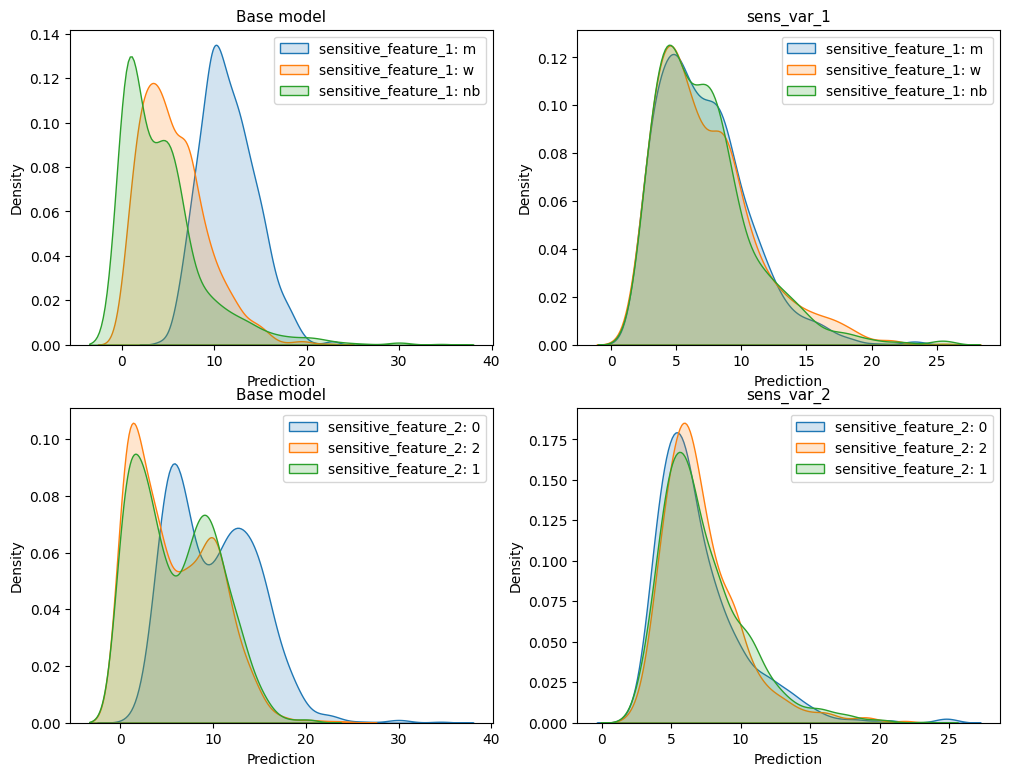

In [11]:
# Visualization of densities before and after exact fairness
viz_fairness_distrib(wst.y_fair_test, x_ssa_test)

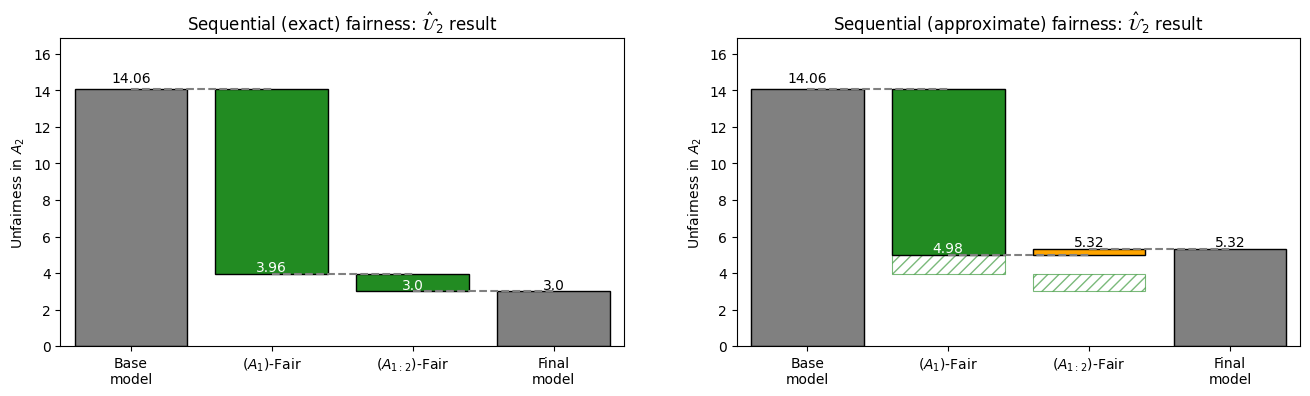

In [12]:
# Waterfall plot
unfs_list = [unfairness_multi(wst.get_sequential_fairness(), x_ssa_test), 
             unfairness_multi(approx_wst.get_sequential_fairness(), x_ssa_test)]

waterfall_plot(unfs_list)

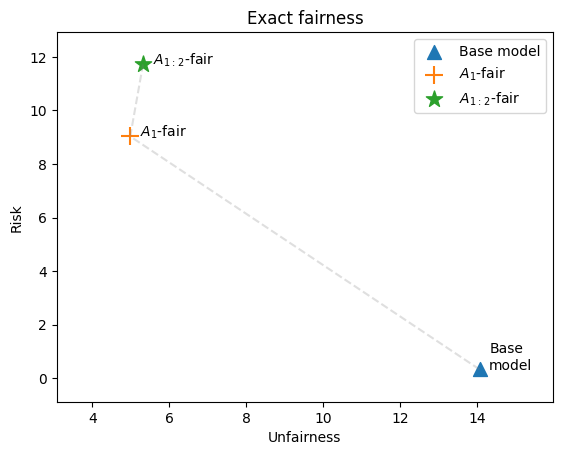

In [13]:
# Single arrow plot
arrow_plot(unfairness_multi(y_fair_dict, x_ssa_test), risk_multi(y_true, y_fair_dict))

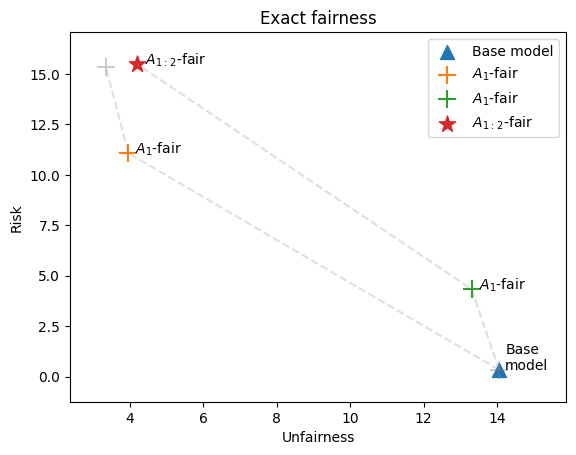

In [19]:
# Arrow plot for all permutations
unfs_list = unfairness_multi_permutations(calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test), 
                                          permutations_cols(x_ssa_test))
risk_list = risk_multi_permutations(y_true,
                                    calculate_perm_wst(y_calib, x_ssa_calib, y_test, x_ssa_test))

arrow_plot_permutations(unfs_list, risk_list)